# Stochastic Variance Reduction Methods for Policy Evaluation

## Convex Optimization: Project

### Team Members:

- Gautham Bellamkonda
- Pranav Kalsanka Nayak


# Problem Statement

Consider the minimization of objective in equation (7) in https://proceedings.mlr.press/v70/du17a/du17a.pdf. Find a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution. Since the primal and dual are unconstrained quadratics, one can solve them using accelerated gradient descent. Note that the per iteration cost is $O(nd^2)$ (assume $n\ge d$) for both primal and dual algos. We already know for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. The paper proposes to solve something "in-between" the primal and dual (saddle-point form), which is equation (10). This problem has both primal and dual variables. The idea is to perform block coordinate (gradient based) descent\&ascent  on primal\&dual variables. The algorithm is in equation (12). The advantage is computing (12) requires only $O(nd)$. Interestingly, in theorem~1, they show this algorithm  also has linear convergence i.e., for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. Thus primal and dual algorithms shall be worse than the proposed primal-dual algorithm.


### a

Derive a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution.

Equation (7) describes the minimization objective:

$$
\text{MSPBE}(\theta) = \frac{1}{2} \| \hat A \theta - \hat b \|^2_{\hat C^{-1}} + \frac{\rho}{2} \| \theta \|^2
$$

To minimize this objective with respect to $\theta$, we introduce the dual variable $w$ and write the Lagrangian as:

$$
\mathcal{L}(\theta, w) = \frac{\rho}{2} \| \theta \|^2 - w^T \hat A \theta - (\frac{1}{2} w^T \hat C w - w^T \hat b)
$$

<!-- Minimizing MSPBE with respect to $\theta$ is equivalent to solving  -->

<!-- $$ -->
<!-- % \min_{\theta} \max_{w} \mathcal{L}(\theta, w) -->
<!-- % $$ -->

Taking the gradient of $\mathcal{L}(\theta, w)$ with respect to $\theta$ and setting it to zero, we get:

\begin{align*}
\rho \theta - \hat A^T w &= 0\\
\theta &= \frac{\hat A^T w}{\rho}
\end{align*}

Substituting this back into the Lagrangian, we get the dual objective:

\begin{align*}
\max_{w} g(w) &= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - (\frac{1}{2} w^T \hat C w - w^T \hat b)\\
&= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - \frac{1}{2} w^T \hat C w + w^T \hat b\\
&= \max_{w} -\frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w + w^T \hat b\\
&= \min_{w} \frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w - w^T \hat b
\end{align*}

The primal solution can be computed using the dual solution as:

$$
\theta^* = \frac{\hat A^T w^*}{\rho}
$$


In [2]:
# code accelerated gradient descent for the primal problem

import numpy as np
import matplotlib.pyplot as plt
import time

#### c

Create a synthetic dataset as outlined in second para in section 8.

In [3]:
# MDP with 400 states and 10 actions. 

NUM_STATES = 400
NUM_ACTIONS = 10
GAMMA = 0.95

# states are represented by 201 dimensional vectors, where the first 200 dimensions are sampled from U[0, 1]
# the last dimension is 1
states = np.random.rand(NUM_STATES, 200)
states = np.concatenate((states, np.ones((NUM_STATES, 1))), axis=1)

# transition probabilities are sampled from U[0, 1]

transition_prob = np.random.rand(NUM_STATES, NUM_ACTIONS, NUM_STATES) + 1e-5
transition_prob = transition_prob / np.sum(transition_prob, axis=2, keepdims=True)

# policy is sampled from U[0, 1]
policy = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5
policy = policy / np.sum(policy, axis=1, keepdims=True)

# start distribution is sampled from U[0, 1]
start_distribution = np.random.rand(NUM_STATES) + 1e-5
start_distribution = start_distribution / np.sum(start_distribution)

# reward function is sampled from U[0, 1]
reward = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5

# sample transitions for T = 20_000
T = 20_000
A = np.zeros((201, 201))
b = np.zeros(201)
C = np.zeros((201, 201))

state = np.random.choice(NUM_STATES, p=start_distribution)
for t in range(T):
    action = np.random.choice(NUM_ACTIONS, p=policy[state])
    next_state = np.random.choice(NUM_STATES, p=transition_prob[state, action])
    r = reward[state, action]
    A += np.outer(states[state], states[state] - GAMMA * states[next_state])
    b += r * states[state]
    C += np.outer(states[state], states[state])
    state = next_state

A /= T
b /= T
C /= T

In [4]:
n = 201

rho = 0.1

hessian = A.T @ np.linalg.pinv(C) @ A + rho * np.eye(n)
eigvals = np.linalg.eigvals(hessian)
L = L_rho = np.max(eigvals)
mu_rho = np.min(eigvals)

dual_hessian = (A @ A.T)/rho + C
dual_eigvals = np.linalg.eigvals(dual_hessian)
L_dual = np.max(dual_eigvals)

mu = 1/L_dual
mu_dual = 1/L

eigenC = np.linalg.eigvals(C)
lambda_min = np.min(eigenC)
lambda_max = np.max(eigenC)

def primal_objective(theta):    # O(d^3)
    return 0.5*((A @ theta - b).T @ np.linalg.pinv(C) @ (A @ theta - b) + rho*np.linalg.norm(theta)**2)
    # return  rho*np.linalg.norm(theta)**2

def primal_gradient(theta):    # O(d^3)
    return A.T @ np.linalg.pinv(C) @ (A @ theta - b) + rho * theta
    # return rho * theta

def dual_objective(w):       # O(d^2.3)
    return -1/(2*rho) *  w.T @ (A@A.T + rho*C) @ w + w.T @ b

def dual_gradient(w):           # O(d^2.3)
    return -1/rho * (A@A.T + rho*C) @ w + b

def lagrangian(theta, w):       # O(d^2)
    return ((rho/2) * theta.T@theta) - w.T @ A @ theta - 0.5 * w.T @ C @ w + w.T @ b

def lagrangian_gradient_primal(theta, w):       # O(d^2)
    return rho * theta - A.T @ w

def lagrangian_gradient_dual(theta, w):     # O(d^2)
    return b - (A @ theta) - (C @ w) 

def optimal_primal():
    return np.linalg.pinv(hessian) @ A.T @ np.linalg.pinv(C) @ b

def optimal_dual():
    return np.linalg.pinv(C) @ (b - A.T @ optimal_primal())

def optimal_primal_value():
    return primal_objective(optimal_primal())

def optimal_dual_value():
    return dual_objective(optimal_dual())

def dual_to_primal(w):
    return (A.T @ w)/rho


#### b

Code the primal accelerated gradient descent, dual accelerated gradient decent and the proposed primal-dual method. You can use any standard formulae in Nesterov's book for acceleration.

In [10]:

def accelerated_gradient_descent_primal(epsilon=1e-9):       # O(loops x d^3) = O(d^3 log(1/epsilon))
    # random initialization
    y_prev = y = x = np.zeros(n)
    objective_values = []
    i = 0
    kappa = 1.5
    l = 1
    l_prev = 0
    while True:
        y = x - 1/L * primal_gradient(x)        # gradient step takes O(d^3) time

        # smooth + strong convexity (primal)
        # gives linear convergence apparently! loops = O(log(1/epsilon)). pretty fast
        x = (1 + (np.sqrt(kappa)-1)/(np.sqrt(kappa) + 1)) * y - (np.sqrt(kappa) -1)/(np.sqrt(kappa) + 1) * y_prev
        
        # smooth only (dual)
        # still, pretty fast convergence for smooth + strong convexity
        # gamma = (1-l_prev)/l
        # x = (1 - gamma) * y + gamma * y_prev
        # l_prev = l
        # l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        
        # ??? some other type of acceleration
        # x = y + (_-1)/(_+2) * (y - y_prev)

        y_prev = y
        objective_values.append(primal_objective(x))
        print(i, primal_objective(x))
        i+=1
        if i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon:  # check for convergence
            break

    # plot the objective value
    plt.plot(objective_values)
    plt.title('Accelerated Primal Gradient Descent Convergence')
    plt.show()
    return objective_values

def accelerated_gradient_ascent_dual(epsilon=1e-9):     # O(loops x d^2.3) = O(d^2.3/epsilon^2)
    y_prev = y = x = np.zeros(n)
    objective_values = []
    i = 0
    kappa = 1.5
    l = 1
    l_prev = 0
    while True:
        y = x + 1/L_dual * dual_gradient(x)     # gradient step takes O(d^2.3) time

        # smooth + strong convexity (primal)
        # x = (1 + (np.sqrt(kappa)-1)/(np.sqrt(kappa) + 1)) * y - (np.sqrt(kappa) -1)/(np.sqrt(kappa) + 1) * y_prev
        
        # smooth only (dual)
        gamma = (1-l_prev)/l
        x = (1 - gamma) * y + gamma * y_prev
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        
        # ??? some other type of acceleration
        # x = y + (_-1)/(_+2) * (y - y_prev)

        y_prev = y
        # objective_values.append(dual_objective(x))  # O(d^2.3)
        objective_values.append(primal_objective(dual_to_primal(x)))
        print(i, primal_objective(dual_to_primal(x)))
        i+=1
        if i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon:  # check for convergence
            break

    # plot the objective value
    plt.plot(objective_values)
    plt.title('Accelerated Dual Gradient Descent Convergence')
    plt.show()
    return objective_values

def primal_dual_gradient_descent(objective, lagrangian_gradient_primal, lagrangian_gradient_dual, epsilon):     # O(loops x d^2) = O(d^2 log(1/epsilon))
    theta = theta_prev = np.zeros(n)
    w = w_prev = np.random.rand(n)
    objective_values = []
    optimal_val = optimal_primal_value()
    print(optimal_val)
    i = 0
    while True:
        theta = theta_prev - (100*lambda_min/(9*lambda_max*L)) * lagrangian_gradient_primal(theta_prev, w_prev)     # O(d^2)
        w = w_prev + (17/(9*lambda_max)) * lagrangian_gradient_dual(theta_prev, w_prev)     # O(d^2)
        objective_values.append(primal_objective(theta))
        print(i, primal_objective(theta))
        i+=1
        theta_prev = theta
        w_prev = w
        if primal_objective(theta) - optimal_val < epsilon or i > 20_000:
            break

    plt.plot(objective_values)
    plt.title('Primal Dual Gradient Descent Convergence')
    plt.show()
    return objective_values

0 0.49357980961794556
1 0.16993420768891307
2 0.10444632595418474
3 0.08451640703525959
4 0.0776980973175305
5 0.07521473543289606
6 0.07427575604796724
7 0.07391190596006855
8 0.07376847562263461
9 0.07371121962045005
10 0.07368814433129431
11 0.07367877489130659
12 0.07367494772337174
13 0.07367337674063644
14 0.07367272922724272
15 0.07367246140422105
16 0.07367235029030877
17 0.07367230406772671
18 0.07367228479325615
19 0.07367227673844295
20 0.07367227336568632
21 0.07367227195079784
22 0.07367227135623204


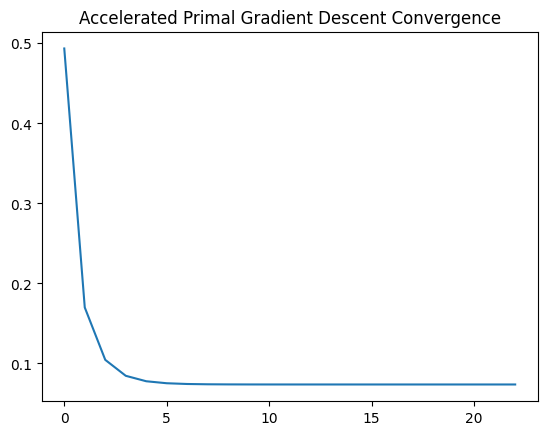

Time taken to run accelerated gradient descent:  0.9266033172607422


In [8]:
start = time.time()
objective_values_primal = accelerated_gradient_descent_primal()
end = time.time()
print("Time taken to run accelerated gradient descent: ", end - start)


0 0.12808675705534114
1 0.08622720036263057
2 0.08617459791274945
3 0.08611129841410488
4 0.08603778814581345
5 0.08595453390720695
6 0.08586200420505971
7 0.08576067825320537
8 0.08565104950317257
9 0.08553362636815702
10 0.08540893136884246
11 0.085277499333969
12 0.08513987501603608
13 0.08499661034269394
14 0.08484826145133564
15 0.08469538561037898
16 0.08453853810533622
17 0.08437826915062678
18 0.08421512087611706
19 0.08404962442978384
20 0.08388229723041725
21 0.08371364039883722
22 0.0835441363922244
23 0.08337424686043639
24 0.08320441074038043
25 0.08303504260029138
26 0.08286653124158505
27 0.0826992385639266
28 0.0825334986942225
29 0.08236961737860687
30 0.08220787163244372
31 0.08204850964119496
32 0.08189175090278572
33 0.08173778659896344
34 0.08158678018164442
35 0.08143886815880005
36 0.08129416106193121
37 0.08115274457692431
38 0.08101468081862989
39 0.08088000972850112
40 0.08074875057541767
41 0.08062090353782472
42 0.08049645134730067
43 0.08037536097264823
44 

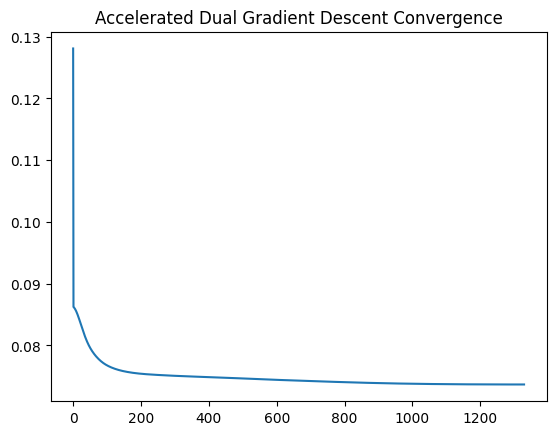

Time taken to run accelerated gradient ascent:  23.934107303619385


In [11]:
start = time.time()
objective_values_dual = accelerated_gradient_ascent_dual()
end = time.time()
print("Time taken to run accelerated gradient ascent: ", end - start)

In [12]:
# the constant involved in algorithmic complexity

(lambda_max/lambda_min)*(L_rho/mu_rho)

211788.4028175459

0.07367227092331444
0 0.12638372133913497
1 0.12785897993037615
2 0.1265102197928395
3 0.12767129437355768
4 0.12660225763534588
5 0.12751519324259405
6 0.12666702701217084
7 0.12738399410015355
8 0.12671023542965182
9 0.12727244196457746
10 0.12673640735139785
11 0.12717640068058333
12 0.12674912636887667
13 0.12709261236581723
14 0.12675122893964105
15 0.1270185094239414
16 0.12674495893986304
17 0.12695206732889533
18 0.12673209068402697
19 0.1268916891390702
20 0.12671402668115417
21 0.12683611478078846
22 0.12669187520780584
23 0.12678434971002978
24 0.1266665118053082
25 0.12673560876533993
26 0.12663862798935469
27 0.1266892719444484
28 0.12660876980681576
29 0.1266448495556592
30 0.12657736834230102
31 0.12660195474374483
32 0.12654476384283475
33 0.12656028182116008
34 0.12651122479197496
35 0.12651958917497935
36 0.12647696298639494
37 0.12647968577935845
38 0.12644214544920307
39 0.12644042055141175
40 0.1264069038440128
41 0.12640167394953625
42 0.12637134191154417
43 0.126

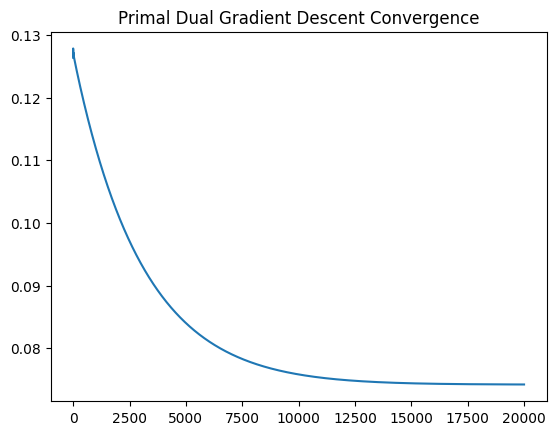

Time taken to run PD gradient descent:  532.927346944809


In [13]:
start = time.time()
objective_values_pd = primal_dual_gradient_descent(lagrangian, lagrangian_gradient_primal, lagrangian_gradient_dual, 1e-6)
end = time.time()
print("Time taken to run PD gradient descent: ", end - start)

#### c

Compare the three algorithms using cpu-time vs objective plots across iterations. Inherently solving saddle-point form is more efficient than solving the primal/dual. Do you observe this from the plots?

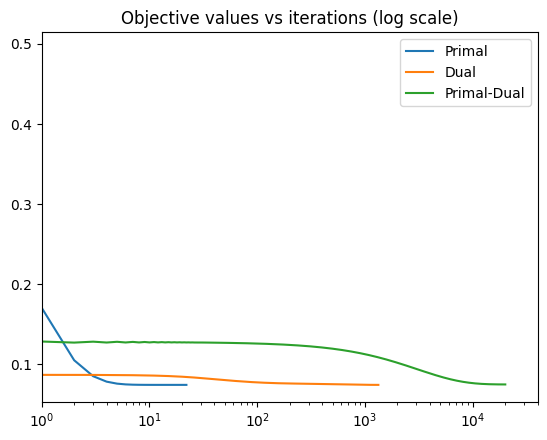

In [14]:
# plot the objective values vs iterations (log scale) for all three methods

plt.plot(objective_values_primal, label="Primal")
plt.plot(objective_values_dual, label="Dual")
plt.plot(objective_values_pd, label="Primal-Dual")
plt.xscale("log")
plt.xlim(1, 2*np.max([len(objective_values_primal), len(objective_values_dual), len(objective_values_pd)]))
plt.legend()
plt.title("Objective values vs iterations (log scale)")
plt.show()

#### d

Now if the regularizer in (7) is $\|\theta\|_1$, derive the saddle-point and dual formulations. Highlight the formula for computing the primal solution using the dual solution

The primal objective with $\ell_1$ regularizer is given by:

$$
\text{MSPBE}(\theta) = \frac{1}{2} \| \hat A \theta - \hat b \|^2_{\hat C^{-1}} + \rho \| \theta \|_1
$$

The saddle-point formulation for the regularizer $\|\theta\|_1$ is given by:

$$
\mathcal{L}(\theta, w) = \frac{\rho}{2} \| \theta \|_1 - w^T \hat A \theta - (\frac{1}{2} w^T \hat C w - w^T \hat b)
$$

The dual objective can be derived by taking the Fenchel dual of the primal objective:

$$
g(w) = \frac{1}{2} w^TCw - w^Tb + I_{A^Tw}(\rho/2)
$$

where $I_{x}(r)$ is the indicator function of the set $\{x: \|x\|_{\infty} \leq r\}$, that is

$$
I_{x}(r) = \begin{cases}
0 & \text{if } \|x\|_{\infty} \leq r\\
\infty & \text{otherwise}
\end{cases}
$$

To compute the primal solution using the dual solution, we can use the following formula:

$$
\theta^* = A^{-1} (b - Cw^*)
$$

where $w^*$ is the optimal dual solution.

In [16]:
def primal_objective_l1(theta):
    return 0.5*((A @ theta - b).T @ np.linalg.pinv(C) @ (A @ theta - b) + (rho/2)*np.linalg.norm(theta, ord=1))

def primal_gradient_l1(theta):
    # return A.T @ np.linalg.pinv(C) @ (A @ theta - b) + (rho/2) * np.sign(theta)
    return A.T @ np.linalg.pinv(C) @ (A @ theta - b)

def dual_objective_l1(w):
    return - 0.5 *  w.T @ C @ w + w.T @ b

def dual_gradient_l1(w):
    return - C @ w + b

def lagrangian_l1(theta, w):
    return (rho/2) * np.linalg.norm(theta, ord=1) - w.T @ A @ theta - 0.5 * w.T @ C @ w + w.T @ b

def lagrangian_gradient_primal_l1(theta, w):
    return (rho/2) * np.sign(theta) - A.T @ w

def lagrangian_gradient_dual_l1(theta, w):
    return b - (A @ theta) - (C @ w)

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def projection(x, threshold):
    # x[x<0] = np.maximum(x[x<0], -threshold)
    # x[x>0] = np.minimum(x[x>0], threshold)
    # return x
    return np.clip(x, -threshold, threshold)

def dual_to_primal_l1(w):
    return np.linalg.pinv(A) @ (b - C @ w)

#### f

On the same synthetic dataset, compare primal accelerated proximal gradient vs dual accelerated proximal gradient vs your proposed primal-proximal-dual-gradient method using cpu-time vs objective plots across iterations. What is your observation from the plots?

In [17]:
def proximal_gradient_descent_primal(epsilon):
    x_prev = x = np.zeros(n)
    time_stamps, objective_values = [], []
    i = 0
    l = 1
    l_prev = 0
    z = x.copy()
    Lr = np.linalg.norm(A) ** 2

    start = time.time()
    while True:
        x_prev = x.copy()
        # z = z + A.T.dot(b - A.dot(z))/Lr
        z = z - (1/Lr + 1/(i+1)) * primal_gradient_l1(z)
        x = soft_thresholding(z, rho/(2*Lr))
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        z = x + (l_prev - 1)/l * (x - x_prev)
        
        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))

        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon) or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Accelerated Proximal Gradient Descent Convergence on Primal L1')
    plt.show()
    return objective_values, time_stamps

def proximal_gradient_ascent_dual(epsilon):
    w_prev = w = np.zeros(n)
    time_stamps, objective_values = [], []
    i = 0
    l = 1
    l_prev = 0
    z = w.copy()
    Lr = np.linalg.norm(C)

    start = time.time()
    while True:
        w_prev = w.copy()
        z = z + 1/Lr * dual_gradient_l1(z)
        w = projection(z, rho/2)
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        z = w + (l_prev - 1)/l * (w - w_prev)

        time_stamps.append(time.time() - start) 
        objective_values.append(primal_objective_l1(dual_to_primal_l1(w)))
        
        print(i, primal_objective_l1(dual_to_primal_l1(w)))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon) or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Accelerated Proximal Gradient Descent Convergence on Dual L1')
    plt.show()
    return objective_values, time_stamps

0 0.14981118955399697
1 0.152335863309007
2 0.15033535270988574
3 0.14509040337423865
4 0.13830810395291773
5 0.13270235567292565
6 0.12948112825558228
7 0.1283704674265459
8 0.1281281069018351
9 0.12809203238030592
10 0.12809208812019918


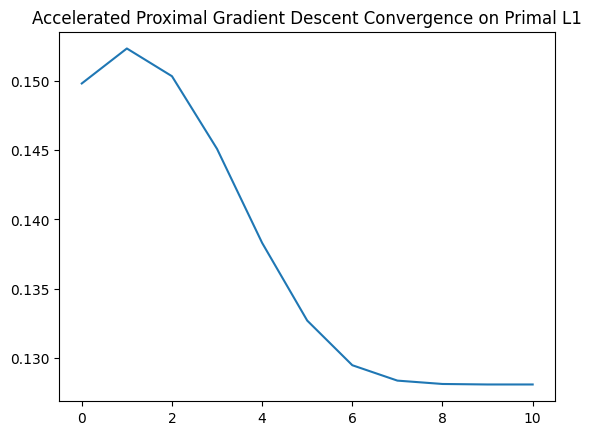

Time taken to run proximal gradient descent:  0.5389382839202881


In [20]:
start = time.time()
objective_values_primal_l1, time_stamps_primal_l1 = proximal_gradient_descent_primal(1e-6)
end = time.time()
print("Time taken to run proximal gradient descent: ", end - start)

0 0.2591488395595401
1 0.2590748642954534
2 0.2589725965900703
3 0.2588486734987801
4 0.25870358675660354
5 0.25853772976989847
6 0.2583514493220982
7 0.2581450677810486
8 0.2579188957142882
9 0.2576732393239347
10 0.2574084050087698
11 0.25712470222005646
12 0.2568252998644378
13 0.2565087013561307
14 0.2561743873195723
15 0.25582268301686845
16 0.2554539202871364
17 0.2550751310630927
18 0.2546900857480607
19 0.2542976002912474
20 0.2538910877300265
21 0.25347011103094574
22 0.2530349991898966
23 0.25258608438348773
24 0.25212370146468327
25 0.2516481874531473
26 0.25115988102661135
27 0.2506591220189488
28 0.25014625092768755
29 0.24962160843665804
30 0.24908614805291987
31 0.24854462872061228
32 0.2480042338734702
33 0.24745442735107892
34 0.24689474338262646
35 0.24633043702027524
36 0.2457627828359334
37 0.24518619238508393
38 0.24460095464971654
39 0.24400735541063767
40 0.24340567708193336
41 0.24279837773694618
42 0.24218681269935416
43 0.24157956080448637
44 0.240975191856058

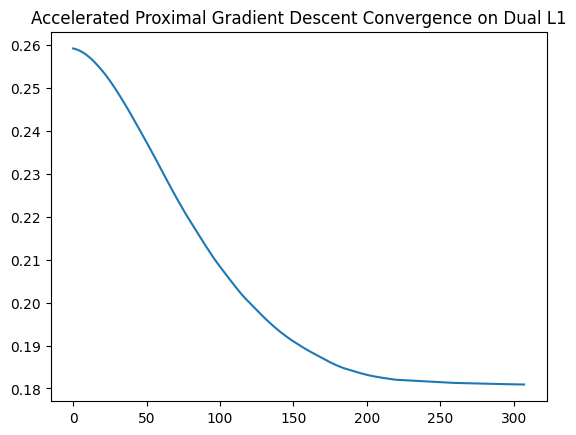

Time taken to run proximal gradient descent:  11.919586420059204


In [21]:
start = time.time()
objective_values_dual_l1, time_stamps_dual_l1 = proximal_gradient_ascent_dual(1e-6)
end = time.time()
print("Time taken to run proximal gradient descent: ", end - start)

In [22]:
def coordinate_prox_gradient_descent_primal(epsilon):
    x = np.ones(n)
    time_stamps, objective_values = [], []
    i = 0
    start = time.time()
    while True:
        for j in range(n):
            # x[j] = soft_thresholding(x[j] + A[j].dot(b - A.dot(x))/L, rho/L)
            x[j] = soft_thresholding(x[j] - 2/L * primal_gradient_l1(x)[j], rho/(2*L))
        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))
        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Coordinate Proximal Gradient Descent Convergence on Primal L1')
    plt.show()
    return objective_values, time_stamps

0 1.4248659451538679
1 0.37818771135994955
2 0.15353274133821757
3 0.12966891709423445
4 0.12864551233252708
5 0.12863002339545793
6 0.12861496380245455
7 0.12860032165248284
8 0.12858608537405627
9 0.12857224371694326
10 0.12855878574219928
11 0.1285457008146571
12 0.12853297859354615
13 0.1285206090248156
14 0.1285085823330839
15 0.12849688901415623
16 0.12848551982709003
17 0.12847446578711072
18 0.12846371815851856
19 0.12845326844785548
20 0.12844310839698994
21 0.12843322997660245
22 0.12842362538022145
23 0.12841428701754012
24 0.12840520750868373
25 0.12839637967843984
26 0.1283877965504449
27 0.1283794513415531
28 0.12837133745697143
29 0.12836344848446513
30 0.12835577818950072
31 0.1283483205106857
32 0.1283410695541132
33 0.12833401958982074
34 0.12832716504638916
35 0.1283205005067991
36 0.12831402070430117
37 0.128307720518043
38 0.12830159496920948
39 0.12829563921708673
40 0.12828984855458764
41 0.1282842184060716
42 0.128278744321824
43 0.12827342197600367
44 0.1282682

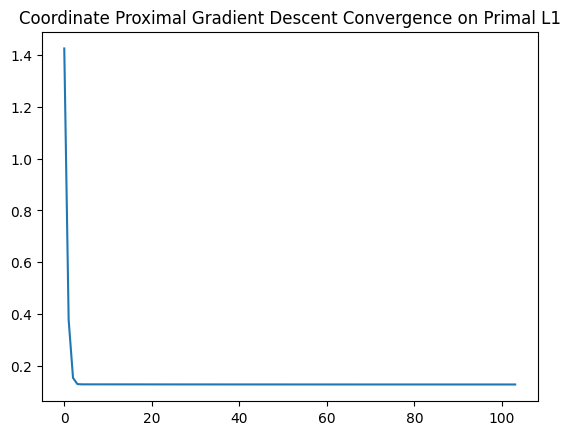

Time taken to run coordinate proximal gradient descent:  183.2046775817871


In [23]:
start = time.time()
objective_values_coord_l1, time_stamps_coord_l1 = coordinate_prox_gradient_descent_primal(1e-6)
end = time.time()
print("Time taken to run coordinate proximal gradient descent: ", end - start)

#### e

Propose an analogous algorithm for this case which does block coordinate optimization using proximal steps for the primal variable and gradient steps for the dual variable. Code this

In [24]:
def coordinate_prox_gradient_descent_primal_dual(epsilon):
    x = np.zeros(n)
    w = np.zeros(n)
    xold = x
    wold = w
    time_stamps, objective_values = [], []
    i = 0
    Lr = np.linalg.norm(A) ** 2
    start = time.time()
    while True:
        for j in range(n):
            x[j] = soft_thresholding(x[j] - (1/Lr + 1/(i+1)) * (rho/2) * (np.sign(x) - A.T @ wold)[j], rho/(20*Lr))
        for j in range(n):
            w[j] = w[j] + (1/Lr + 1/(i+1)) * (b - (A @ xold) - (C @ w))[j]

        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))
        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Coordinate Proximal Primal-Dual GD on L1')
    plt.show()
    return objective_values, time_stamps

0 0.12808675705534114
1 0.1281055901244858
2 0.13381995908560712
3 0.12858341738647738
4 0.1292415814767494
5 0.1280945586940388
6 0.1284921315804488
7 0.12809294287419196
8 0.12844031247419152
9 0.12809445929464885
10 0.12840087092920732
11 0.12809740164500147
12 0.12836877293223345
13 0.12810105239580288
14 0.12834147109882305
15 0.12810506777723352
16 0.12831752395340798
17 0.1281092678978904
18 0.1282960469737039
19 0.12811355263368168
20 0.12827646290463765
21 0.128117863807841
22 0.12825837628940676
23 0.12812216664670162
24 0.12824150537036524
25 0.1281264400482478
26 0.12822564278012763
27 0.1281306711938649
28 0.12821063168225103
29 0.12813485242802178
30 0.12819635066607135
31 0.1281389793856665
32 0.12818270383965852
33 0.12814304983344602
34 0.12816961412960223
35 0.12814706293300687
36 0.1281570186270099
37 0.12815101876509197
38 0.1281448652809441
39 0.12815491801339832
40 0.12813311049725257
41 0.128158761754203
42 0.12812171736641553
43 0.12816255131364118
44 0.12811065

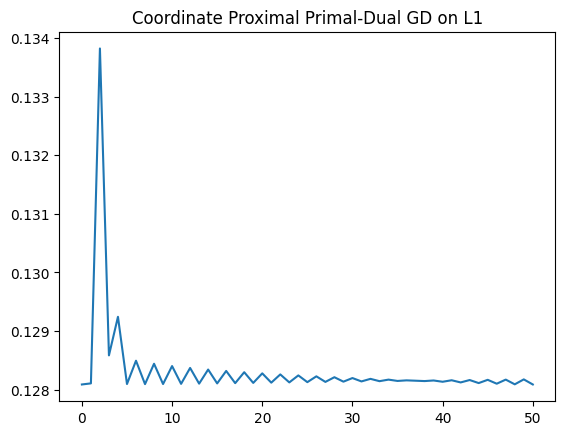

Time taken to run coordinate proximal gradient descent:  1.6610183715820312


In [25]:
start = time.time()
objective_values_pd_l1, time_stamps_pd_l1 = coordinate_prox_gradient_descent_primal_dual(1e-6)
end = time.time()
print("Time taken to run coordinate proximal gradient descent: ", end - start)

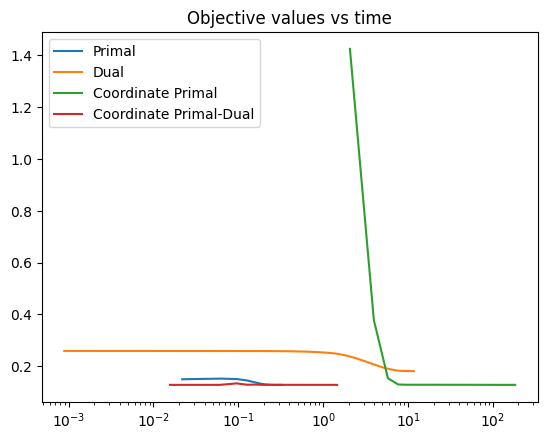

In [26]:
# plot the objective values vs time for all three methods

plt.plot(time_stamps_primal_l1, objective_values_primal_l1, label="Primal")
plt.plot(time_stamps_dual_l1, objective_values_dual_l1, label="Dual")
plt.plot(time_stamps_coord_l1, objective_values_coord_l1, label="Coordinate Primal")
plt.plot(time_stamps_pd_l1, objective_values_pd_l1, label="Coordinate Primal-Dual")
plt.legend()
plt.xscale("log")
plt.title("Objective values vs time")
plt.show()


#### g

Now, consider a high-dimensional setting where $n << d$. Then, will the primal acc.gr. descent be still as computationally efficient as the dual acc.gr. descent? With theoretical arguments, in this setting, can you compare the efficiency of primal-dual vs dual algorithms. Is there a trade-off or is there a clear winner ?

Ans.

For the first part, we cannot really say. The complexity of the primal accelerated gradient descent is $O(d^3 \log(1/\epsilon))$, while the complexity of the dual accelerated gradient descent is $O(d^{2.3} /\epsilon^2)$. We need information about $\epsilon$ to compare the two.

For the second part, we can say that the primal-dual algorithm is more efficient than the dual algorithm. The primal-dual algorithm has a complexity of $O(d^2 \log(1/\epsilon))$, while the dual algorithm has a complexity of $O(d^{2.3} /\epsilon^2)$. The primal-dual algorithm is more efficient than the dual algorithm. However, for practical use, the dual algorithm seems to be more practical, as it has lower runtimes. This can be understood from the plots in the previous parts. One reason for this could be the explosive constants involved in the complexity of the primal-dual algorithm.

Thank You!